LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California.[3] It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. LendingClub is the world's largest peer-to-peer lending platform.

#### Our Goal
Given historical data on loans given out with information on whether or not the borrower defaulted (charge-off), can we build a model thatcan predict wether or nor a borrower will pay back their loan? This way in the future when we get a new potential customer we can assess whether or not they are likely to pay back the loan. Keep in mind classification metrics when evaluating the performance of your model!

The "loan_status" column contains our label.

In [494]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [495]:
data_info = pd.read_csv('lending_club_info.csv',index_col='LoanStatNew')
df = pd.read_csv('lending_club_loan_two.csv')

In [496]:
print(data_info.loc['revol_util']['Description'])

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.


In [497]:
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [498]:
feat_info('mort_acc')

Number of mortgage accounts.


In [499]:
## check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [500]:
##few variables with NULL values

### Exploratory Data Analysis

In [501]:
## Countplot of loan_status

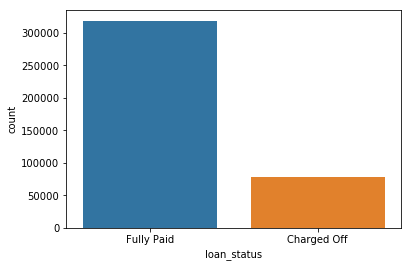

In [502]:
sns.countplot(df['loan_status'])

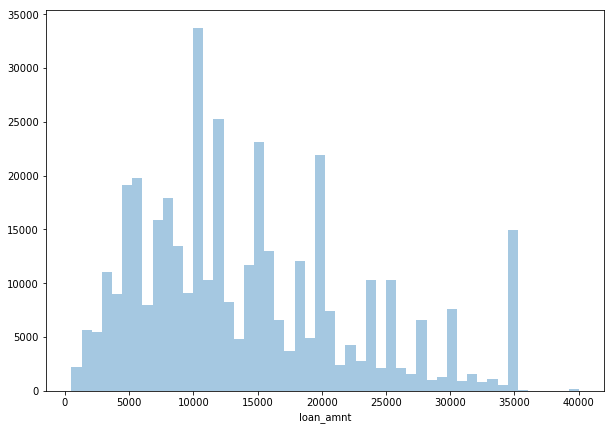

In [503]:
## historgram of loan amount column
plt.figure(figsize=(10,7))
sns.distplot(df['loan_amnt'], kde=False)

In [504]:
## Correlation between numerical variables
df_corr = df.select_dtypes(include=['float64'])
df_corr = df_corr.corr()

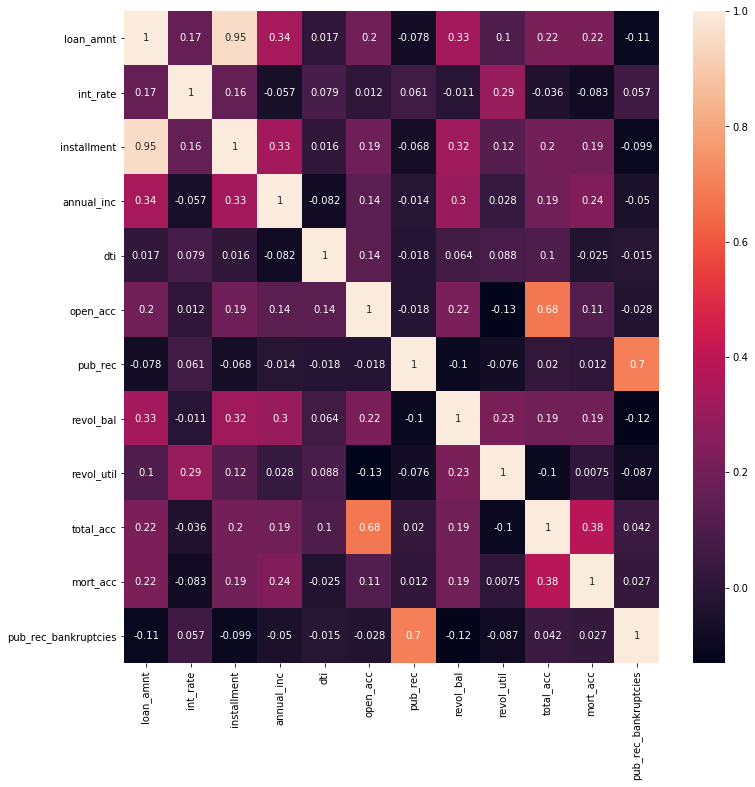

In [505]:
plt.figure(figsize=(12,12))
sns.heatmap(df_corr, annot=True)

almost perfect correlations between installment and loan_amount

In [506]:
feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


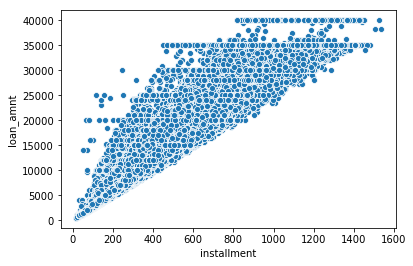

In [507]:
sns.scatterplot(x='installment', y='loan_amnt', data=df)

this seems like duplicate information, as the installment indicates a subset of the loan_amnt to be paid.

In [508]:
## drop installment variable
#df = df.drop['installment', axis =1]

#### a boxplot showing the relationship between the loan_status and the Loan Amount.

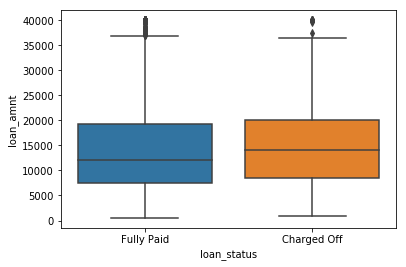

In [509]:
sns.boxplot(x='loan_status', y='loan_amnt', data = df)

#### summary statistics for the loan amount, grouped by the loan_status.

In [510]:
df['loan_amnt'].groupby(df['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [511]:
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [512]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

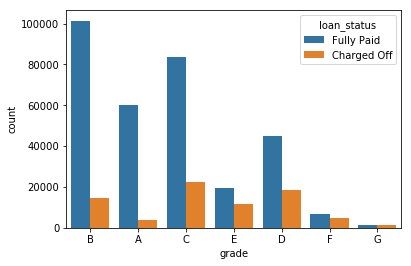

In [513]:
sns.countplot(df['grade'], hue='loan_status', data=df)

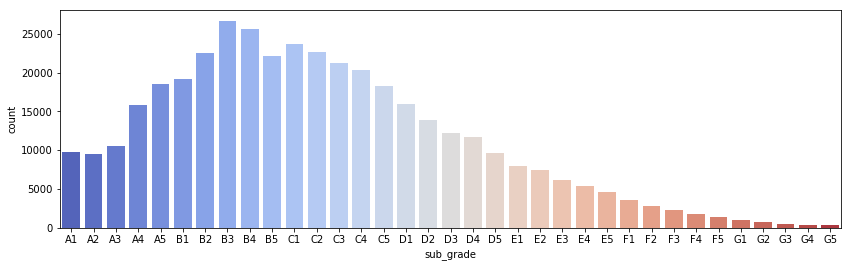

In [514]:
### count plot of loan sub_grades
plt.figure(figsize=(14,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade', data=df, order=subgrade_order, palette='coolwarm')

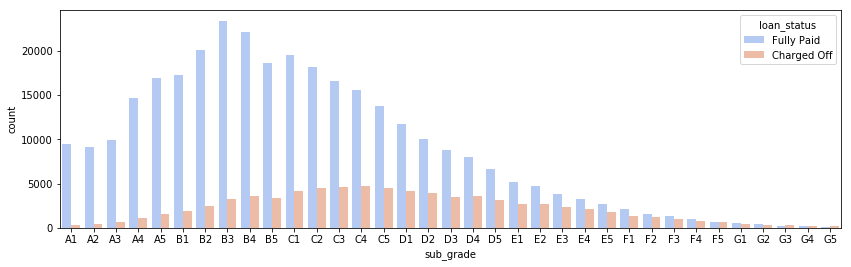

In [515]:
### count plot of loan sub_grades
plt.figure(figsize=(14,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade', hue=df['loan_status'] ,data=df, order=subgrade_order, palette='coolwarm')

 It looks like F and G subgrades don't get paid back that often. Isloate those and recreate the countplot just for those subgrades.

In [516]:
df_fg = df[(df.grade == 'F') | (df.grade =='G')]

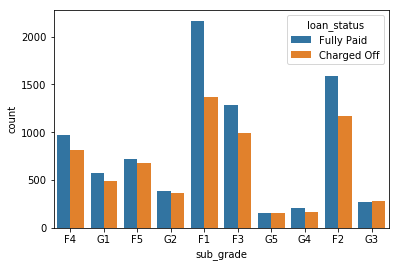

In [517]:
sns.countplot('sub_grade', data=df_fg, hue='loan_status')

between grades F & G, subgroups G5, G4, G3,F3 and others seem highly likely to fail

###### a new column called 'loan_repaid' which will contain a 1 if the loan status was "Fully Paid" and a 0 if it was "Charged Off".

In [518]:
loan_status = pd.get_dummies(df['loan_status'], drop_first=True)
loan_status.columns = ['loan_repaid']
loan_status.head(10)

,loan_repaid
0,1
1,1
2,1
3,1
4,0
5,1
6,1
7,1
8,1
9,1


In [519]:
df.drop(['loan_status'], axis=1,inplace=True)
df = pd.concat([df, loan_status], axis=1)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_repaid
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0


 ###### a bar plot showing the correlation of the numeric features to the new loan_repaid column. Helpful Link

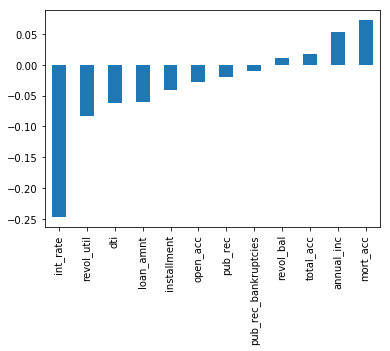

In [520]:
df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')

### Data Pre Processing 

###### Remove or fill any missing data. Remove unnecessary or repetitive features. Convert categorical string features to dummy variables.

In [521]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_repaid
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0


In [522]:
df.shape
## total rows = 396,030

(396030, 27)

In [523]:
(df.isnull().sum() /396030) *100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [524]:
feat_info('emp_title')
feat_info('emp_length')

The job title supplied by the Borrower when applying for the loan.*
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [525]:
print(len(df['emp_title']))

396030


In [526]:
df['emp_title'].value_counts()

Teacher                                   4389
Manager                                   4250
Registered Nurse                          1856
RN                                        1846
Supervisor                                1830
Sales                                     1638
Project Manager                           1505
Owner                                     1410
Driver                                    1339
Office Manager                            1218
manager                                   1145
Director                                  1089
General Manager                           1074
Engineer                                   995
teacher                                    962
driver                                     882
Vice President                             857
Operations Manager                         763
Administrative Assistant                   756
Accountant                                 748
President                                  742
owner        

In [527]:
### too many job titles to model, remove
df.drop('emp_title', axis=1,inplace=True)

#### a count plot of the emp_length feature column. Sort the order of the values.

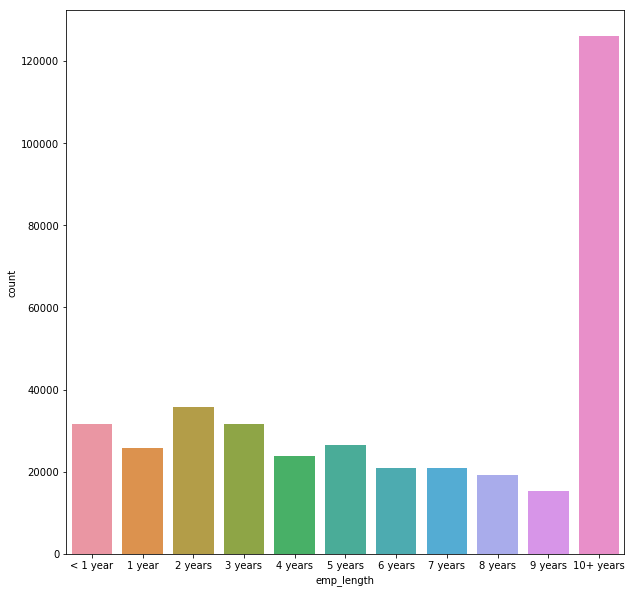

In [528]:
df.head()
df['emp_length'].unique()
SORT_ORDER = {"< 1 year": 1, "1 year": 2, "2 years": 3, "3 years": 3,"4 years": 5, "5 years": 6, "6 years": 7, "7 years": 8, 
          '8 years': 9,"9 years": 10, "10+ years": 11
#       ,nan
         }
emp_length = df['emp_length']

plt.figure(figsize=(10,10))
sns.countplot(df['emp_length'], order = SORT_ORDER, data=df)

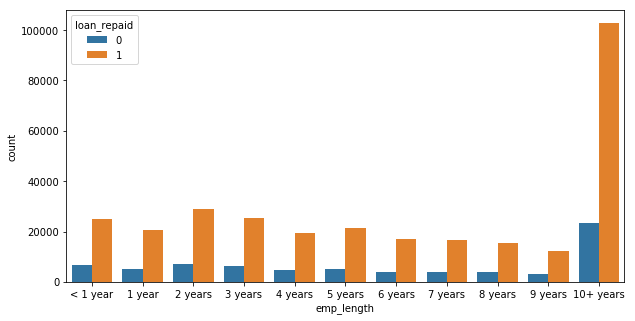

In [529]:
plt.figure(figsize=(10,5))
sns.countplot(df['emp_length'], order = SORT_ORDER, data=df, hue='loan_repaid')

This still doesn't really inform us if there is a strong relationship between employment length and being charged off, what we want is the percentage of charge offs per category. Essentially informing us what percent of people per employment category didn't pay back their loan. There are a multitude of ways to create this Series. Once you've created it, see if visualize it with a bar plot. This may be tricky, refer to solutions if you get stuck on creating this Series.

In [530]:
emp_fp = df[df['loan_repaid']==1].groupby("emp_length").count()['loan_repaid']

In [531]:
emp_co = df[df['loan_repaid']==0].groupby("emp_length").count()['loan_repaid']

In [532]:
emp_len = emp_co/emp_fp

In [533]:
emp_len

emp_length
1 year       0.248649
10+ years    0.225770
2 years      0.239560
3 years      0.242593
4 years      0.238213
5 years      0.237911
6 years      0.233341
7 years      0.241887
8 years      0.249625
9 years      0.250735
< 1 year     0.260830
Name: loan_repaid, dtype: float64

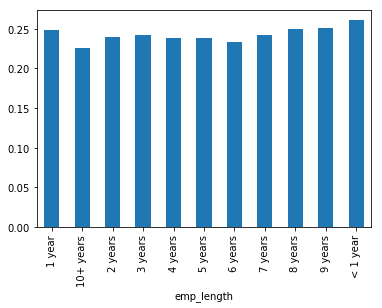

In [534]:
emp_len.plot(kind='bar')

In [535]:
df = df.drop('emp_length', axis=1)

In [536]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

Review the title column vs the purpose column. Is this repeated information?

In [537]:
df['title'].unique()

array(['Vacation', 'Debt consolidation', 'Credit card refinancing', ...,
       'Credit buster ', 'Loanforpayoff', 'Toxic Debt Payoff'],
      dtype=object)

In [538]:
df['purpose'].unique()

array(['vacation', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'major_purchase', 'other',
       'medical', 'wedding', 'car', 'moving', 'house', 'educational',
       'renewable_energy'], dtype=object)

In [539]:
## seems like the same information - drop the title variable
df.drop('title', axis=1, inplace=True)

In [540]:
feat_info('mort_acc')

Number of mortgage accounts.


In [541]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

there are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or you could even bin the columns into categories and then set NaN as its own category. There is no 100% correct approach! Let's review the other columsn to see which most highly correlates to mort_acc

In [542]:
## Mort accounts correlations with other variables
df_corr = df.corr()

In [543]:
df_corr['mort_acc']

loan_amnt               0.222315
int_rate               -0.082583
installment             0.193694
annual_inc              0.236320
dti                    -0.025439
open_acc                0.109205
pub_rec                 0.011552
revol_bal               0.194925
revol_util              0.007514
total_acc               0.381072
mort_acc                1.000000
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
Name: mort_acc, dtype: float64

Looks like the total_acc feature correlates with the mort_acc , this makes sense! Let's try this fillna() approach. We will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry. To get the result below:

In [544]:
feat_info('total_acc')

The total number of credit lines currently in the borrower's credit file


In [545]:
df.groupby('total_acc')['mort_acc'].mean()

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
7.0      0.221695
8.0      0.308422
9.0      0.365499
10.0     0.429158
11.0     0.526570
12.0     0.618034
13.0     0.722124
14.0     0.803482
15.0     0.940142
16.0     1.007405
17.0     1.151269
18.0     1.235885
19.0     1.358013
20.0     1.409380
21.0     1.519932
22.0     1.640736
23.0     1.721794
24.0     1.845867
25.0     1.900506
26.0     1.987414
27.0     2.103573
28.0     2.163050
29.0     2.231043
30.0     2.331386
31.0     2.390104
           ...   
90.0     2.000000
91.0     3.333333
92.0     5.000000
93.0     2.111111
94.0     2.909091
95.0     1.800000
96.0     3.000000
97.0     4.500000
98.0     0.500000
99.0     4.200000
100.0    4.000000
101.0    2.500000
102.0    3.500000
103.0    0.000000
104.0    8.000000
105.0    3.666667
106.0    1.500000
107.0    3.000000
108.0    0.000000
110.0    3.000000
111.0    2.000000
115.0    8.000000
116.0    4.500000
117.0    0.000000


Fill in the missing mort_acc values based on their total_acc value. If the mort_acc is missing, then we will fill in that missing value with the mean value corresponding to its total_acc value from the Series we created above. 

In [546]:
men_total_acc = df.groupby('total_acc')['mort_acc'].mean()

In [547]:
## if mort_acc is missing then give them the average mort_acc based on their total_acc value
def impute_mort_acc(total_acc,mort_acc):
      
    if np.isnan(mort_acc):
        return men_total_acc[total_acc]
    else:
        return mort_acc
    

In [548]:
df['mort_acc'] = df.apply(lambda x: impute_mort_acc(x['total_acc'],x['mort_acc']), axis=1)

In [549]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [550]:
## drop rows of revol_util and pub_Rec
df = df.dropna()

### Categorical and Dummy Variables

In [551]:
df.select_dtypes(include=['object'])

,term,grade,sub_grade,home_ownership,verification_status,issue_d,purpose,earliest_cr_line,initial_list_status,application_type,address
0,36 months,B,B4,RENT,Not Verified,Jan-2015,vacation,Jun-1990,w,INDIVIDUAL,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,36 months,B,B5,MORTGAGE,Not Verified,Jan-2015,debt_consolidation,Jul-2004,f,INDIVIDUAL,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,36 months,B,B3,RENT,Source Verified,Jan-2015,credit_card,Aug-2007,f,INDIVIDUAL,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,36 months,A,A2,RENT,Not Verified,Nov-2014,credit_card,Sep-2006,f,INDIVIDUAL,"823 Reid Ford\nDelacruzside, MA 00813"
4,60 months,C,C5,MORTGAGE,Verified,Apr-2013,credit_card,Mar-1999,f,INDIVIDUAL,"679 Luna Roads\nGreggshire, VA 11650"
5,36 months,C,C3,MORTGAGE,Verified,Sep-2015,debt_consolidation,Jan-2005,f,INDIVIDUAL,1726 Cooper Passage Suite 129\nNorth Deniseber...
6,36 months,A,A1,MORTGAGE,Source Verified,Sep-2015,home_improvement,Aug-2005,f,INDIVIDUAL,"1008 Erika Vista Suite 748\nEast Stephanie, TX..."
7,36 months,B,B2,RENT,Not Verified,Sep-2012,credit_card,Sep-1994,f,INDIVIDUAL,USCGC Nunez\nFPO AE 30723
8,60 months,B,B3,RENT,Verified,Oct-2014,debt_consolidation,Jun-1994,w,INDIVIDUAL,USCGC Tran\nFPO AP 22690
9,36 months,C,C5,MORTGAGE,Verified,Apr-2012,debt_consolidation,Dec-1997,f,INDIVIDUAL,"3390 Luis Rue\nMauricestad, VA 00813"


In [552]:
## convert 'term' feature
def term(term):
    if term == '36 months':
        return '36'
    else:
        return '60'

In [553]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))

In [554]:
df = df.drop('grade', axis=1)

In [555]:
dummies = pd.get_dummies(df['sub_grade'], drop_first=True)
df = pd.concat([df.drop('sub_grade', axis=1),dummies],axis=1)

In [556]:
dummies = pd.get_dummies(df[['verification_status', 'application_type','initial_list_status','purpose']], drop_first=True)
df = pd.concat([df.drop(['verification_status', 'application_type','initial_list_status','purpose'], axis=1),dummies],axis=1)

In [557]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [558]:
### put he 'None' and "Any' into 'Other' category
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'],'OTHER')

In [559]:
dummies = pd.get_dummies(df['home_ownership'], drop_first=True)

df = pd.concat([df.drop('home_ownership', axis=1), dummies],axis=1)

####  Let's feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.

In [560]:
## zipcode is always the last 5 digits
df['zip_code'] =df['address'].apply(lambda address:address[-5:])

In [561]:
df['zip_code'].value_counts()

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

In [562]:
dummies = pd.get_dummies(df['zip_code'], drop_first=True)

df = pd.concat([df.drop('zip_code', axis=1), dummies],axis=1)

In [563]:
df = df.drop('address', axis =1)

In [564]:
feat_info('issue_d')

The month which the loan was funded


In [565]:
df = df.drop('issue_d', axis=1)

In [566]:
feat_info('earliest_cr_line')

The month the borrower's earliest reported credit line was opened


In [567]:
### lets extract the year from this feature
#df['earliest_cr_line']
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda address:address[-4:])
df = df.drop('earliest_cr_line', axis=1)

### Split data into train, test, split

In [568]:
from sklearn.model_selection import train_test_split

In [578]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
loan_amnt                              395219 non-null float64
term                                   395219 non-null int64
int_rate                               395219 non-null float64
installment                            395219 non-null float64
annual_inc                             395219 non-null float64
dti                                    395219 non-null float64
open_acc                               395219 non-null float64
pub_rec                                395219 non-null float64
revol_bal                              395219 non-null float64
revol_util                             395219 non-null float64
total_acc                              395219 non-null float64
mort_acc                               395219 non-null float64
pub_rec_bankruptcies                   395219 non-null float64
loan_repaid                            395219 non-null uint8
A2         

In [572]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [580]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [574]:
from sklearn.preprocessing import MinMaxScaler

In [575]:
scaler = MinMaxScaler()

In [582]:
X_train = scaler.fit_transform(X_train)

C:\Users\yasit\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [581]:
X_test = scaler.transform(X_test)

## Creating the model

In [583]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [584]:
# CODE HERE
model = Sequential()

# Choose whatever number of layers/neurons you want.

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# Remember to compile()

In [585]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw


# input layer
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

Fit the model to the training data for at least 25 epochs. Also add in the validation data for later plotting. Optional: add in a batch_size of 256.

In [586]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size= 256,
          validation_data=(X_test, y_test), verbose=1
          )

Train on 316175 samples, validate on 79044 samples
Epoch 1/25
316175/316175 [==============================] - 5s 15us/sample - loss: 0.3008 - val_loss: 0.2646
Epoch 2/25
316175/316175 [==============================] - 5s 17us/sample - loss: 0.2656 - val_loss: 0.2629
Epoch 3/25
316175/316175 [==============================] - 4s 13us/sample - loss: 0.2630 - val_loss: 0.2627
Epoch 4/25
316175/316175 [==============================] - 5s 15us/sample - loss: 0.2618 - val_loss: 0.2624
Epoch 5/25
316175/316175 [==============================] - 4s 13us/sample - loss: 0.2609 - val_loss: 0.2621
Epoch 6/25
316175/316175 [==============================] - 4s 12us/sample - loss: 0.2602 - val_loss: 0.2618
Epoch 7/25
316175/316175 [==============================] - 4s 12us/sample - loss: 0.2599 - val_loss: 0.2613
Epoch 8/25
316175/316175 [==============================] - 4s 11us/sample - loss: 0.2595 - val_loss: 0.2615
Epoch 9/25
316175/316175 [==============================] - 4s 11us/sample - 

In [587]:
from tensorflow.keras.models import load_model
model.save('full_data_project_model.h5')  

In [588]:
losses = pd.DataFrame(model.history.history)

In [589]:
losses.head()

,loss,val_loss
0,0.300786,0.264621
1,0.265567,0.262857
2,0.263038,0.262726
3,0.261754,0.262433
4,0.260949,0.262052


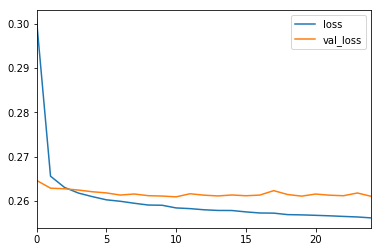

In [590]:
losses.plot()

Create predictions from the X_test set and display a classification report and confusion matrix for the X_test set.

In [591]:
from sklearn.metrics import classification_report,confusion_matrix

In [592]:
predictions = model.predict_classes(X_test)

In [593]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.97      0.45      0.61     15658
          1       0.88      1.00      0.93     63386

avg / total       0.90      0.89      0.87     79044



In [595]:
import random
random.seed(101)
random_ind = random.randint(0,len(df))

new_customer = df.drop('loan_repaid',axis=1).iloc[random_ind]
new_customer

loan_amnt                        25000
term                                60
int_rate                         18.24
installment                     638.11
annual_inc                       61665
dti                              30.11
open_acc                            16
pub_rec                              0
revol_bal                        27778
revol_util                        65.5
total_acc                           46
mort_acc                             0
pub_rec_bankruptcies                 0
A2                                   0
A3                                   0
A4                                   0
A5                                   0
B1                                   0
B2                                   0
B3                                   0
B4                                   0
B5                                   0
C1                                   0
C2                                   0
C3                                   0
C4                       

In [596]:
model.predict_classes(new_customer.values.reshape(1,78))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).